<a href="https://colab.research.google.com/github/Piyush01Bhatt/Deep-Learning/blob/master/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 66kB/s 
     |████████████████████████████████| 501kB 39.2MB/s 
     |████████████████████████████████| 3.1MB 29.6MB/s 


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
tf.__version__

'2.0.0-beta1'

In [0]:
!wget http://www.manythings.org/anki/hin-eng.zip

--2019-08-14 12:38:01--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89831 (88K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>]  87.73K   369KB/s    in 0.2s    

2019-08-14 12:38:01 (369 KB/s) - ‘hin-eng.zip’ saved [89831/89831]



In [0]:
!unzip hin-eng.zip

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


In [0]:
with open('hin.txt','r') as f:
  data = f.read().splitlines()
print(data[0])

Wow!	वाह!


In [0]:
eng,hin = data[2807].split('\t')

In [0]:
eng

"Make a good translation of the sentence that you are translating. Don't let translations into other languages influence you."

In [0]:
hin

'आप जिस वाक्य का अनुवाद कर रहे हैं, उस ही का अच्छी तरह से अनुवाद करें। दूसरी भाषाओं के अनुवादों से प्रभावित न होने दें।'

In [0]:
hin[-1] == '।'

True

In [0]:
len(data)

2808

In [0]:
def preprocess_sentence(w,typ='hin'):
  if typ == 'eng':
    w = w.lower().strip()
    w = re.sub(r"i'm","i am", w)
    w = re.sub(r"he's","he is", w)
    w = re.sub(r"she's","she is", w)
    w = re.sub(r"that's","that is", w)
    w = re.sub(r"it's","it is", w)
    w = re.sub(r"what's","what is", w)
    w = re.sub(r"where's","where is", w)
    w = re.sub(r"who's","who is", w)
    w = re.sub(r"\'ll"," will", w)
    w = re.sub(r"\'ve"," have", w)
    w = re.sub(r"\'d"," would", w)
    w = re.sub(r"\'re"," are", w)
    w = re.sub(r"won't","will not", w)
    w = re.sub(r"can't","cannot", w)
    w = re.sub(r"don't","do not", w)
    w = re.sub(r"did't","did not", w)
    
  w = re.sub(r"([?.!,।])",r" \1 ",w)
  w = re.sub(r'[" "]+', " ", w)
  
  if typ == 'eng':
    w = re.sub(r"[^a-zA-Z?.!,]+"," ", w)
  
  w = w.rstrip().strip()
  w = '<start> ' + w + ' <end>'
  return w



In [0]:
print(preprocess_sentence(hin))

<start> आप जिस वाक्य का अनुवाद कर रहे हैं , उस ही का अच्छी तरह से अनुवाद करें । दूसरी भाषाओं के अनुवादों से प्रभावित न होने दें । <end>


In [0]:
print(preprocess_sentence(eng,typ='eng'))

<start> make a good translation of the sentence that you are translating . do not let translations into other languages influence you . <end>


In [0]:
eng_data = []
hin_data = []
for line in data:
  eng,hin = line.split('\t')
  eng_data.append(preprocess_sentence(eng,typ='eng'))
  hin_data.append(preprocess_sentence(hin))
print(eng_data[0:10])
print(hin_data[0:10])

['<start> wow ! <end>', '<start> help ! <end>', '<start> jump . <end>', '<start> jump . <end>', '<start> jump . <end>', '<start> hello ! <end>', '<start> hello ! <end>', '<start> cheers ! <end>', '<start> cheers ! <end>', '<start> got it ? <end>']
['<start> वाह ! <end>', '<start> बचाओ ! <end>', '<start> उछलो . <end>', '<start> कूदो . <end>', '<start> छलांग . <end>', '<start> नमस्ते । <end>', '<start> नमस्कार । <end>', '<start> वाह-वाह ! <end>', '<start> चियर्स ! <end>', '<start> समझे कि नहीं ? <end>']


In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token = '<oov>')
  lang_tokenizer.fit_on_texts(lang,)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [0]:
eng_data = np.array(eng_data)
hin_data = np.array(hin_data)
np.random.seed(5)
msk = np.random.rand(len(eng_data)) < 0.8

In [0]:
msk

array([ True, False,  True, ...,  True,  True,  True])

In [0]:
eng_tensor,eng_tokenizer = tokenize(eng_data)
hin_tensor,hin_tokenizer = tokenize(hin_data)

In [0]:
len(eng_tokenizer.word_index)

2329

In [0]:
len(hin_tokenizer.word_index)

2873

In [0]:
train_eng = eng_tensor[msk]
train_hin = hin_tensor[msk]
test_eng = eng_tensor[~msk]
test_hin = hin_tensor[~msk]

In [0]:
test_eng[0]

array([ 2, 95, 62,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [0]:
test_hin[0]

array([   2, 1421,   75,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [0]:
reverse_eng_word_index = {v:k for k,v in eng_tokenizer.word_index.items()}
reverse_hin_word_index = {v:k for k,v in hin_tokenizer.word_index.items()}

In [0]:
w = []
for word in test_eng[0]:
  if word in reverse_eng_word_index:
    w.append(reverse_eng_word_index[word])
print(w)

['<start>', 'help', '!', '<end>']


In [0]:
w = []
for word in test_hin[0]:
  if word in reverse_hin_word_index:
    w.append(reverse_hin_word_index[word])
print(w)

['<start>', 'बचाओ', '!', '<end>']


In [0]:
BUFFER_SIZE = len(eng_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(eng_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_input_size = len(eng_tokenizer.word_index)+1
vocab_tar_size = len(hin_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((eng_tensor,hin_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
ex_inp_batch, ex_tar_batch = next(iter(dataset))
ex_inp_batch.shape, ex_tar_batch.shape

(TensorShape([64, 28]), TensorShape([64, 30]))

**ENCODER**

In [0]:
class Encoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
    
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
    

In [0]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

# SAMPLE INPUT
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(ex_inp_batch, sample_hidden)

print (f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 28, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


**Bahdanau Attention**

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query,1) # dimension == (batch,1,hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)
    ))
    attention_weights = tf.nn.softmax(score, axis=1) # dimension = (batch, max_seq_length, 1)

    context_vector = attention_weights * values  # dimension = (batch, max_seq_length,hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1) #dimension = (batch, hidden_size)

    return context_vector, attention_weights


In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 28, 1)


**DECODER**

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder,self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x) # dims_out = (batch, 1, embedding_dims)
    x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)
    output,state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (64, 2874)


**Optimizer and loss functions**

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

 **Creating Checkpoint**

In [0]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Training**

In [0]:
@tf.function
def train_step(inp,tar,enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp,enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([hin_tokenizer.word_index['<start>']]*BATCH_SIZE,1)
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [0]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 2 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.4054
Epoch 1 Batch 2 Loss 2.3593
Epoch 1 Batch 4 Loss 2.1187
Epoch 1 Batch 6 Loss 1.5574
Epoch 1 Batch 8 Loss 1.5463
Epoch 1 Batch 10 Loss 1.5462
Epoch 1 Batch 12 Loss 1.5421
Epoch 1 Batch 14 Loss 1.5096
Epoch 1 Batch 16 Loss 1.4582
Epoch 1 Batch 18 Loss 1.4322
Epoch 1 Batch 20 Loss 1.4313
Epoch 1 Batch 22 Loss 1.4273
Epoch 1 Batch 24 Loss 1.4043
Epoch 1 Batch 26 Loss 1.3917
Epoch 1 Batch 28 Loss 1.3801
Epoch 1 Batch 30 Loss 1.3667
Epoch 1 Batch 32 Loss 1.3522
Epoch 1 Batch 34 Loss 1.3363
Epoch 1 Batch 36 Loss 1.3207
Epoch 1 Batch 38 Loss 1.3032
Epoch 1 Batch 40 Loss 1.2854
Epoch 1 Batch 42 Loss 1.2656
Epoch 1 Loss 1.5217
Time taken for 1 epoch 107.23817014694214 sec

Epoch 2 Batch 0 Loss 1.2545
Epoch 2 Batch 2 Loss 1.2325
Epoch 2 Batch 4 Loss 1.2056
Epoch 2 Batch 6 Loss 1.1755
Epoch 2 Batch 8 Loss 1.1418
Epoch 2 Batch 10 Loss 1.1064
Epoch 2 Batch 12 Loss 1.0680
Epoch 2 Batch 14 Loss 1.0280
Epoch 2 Batch 16 Loss 0.9843
Epoch 2 Batch 18 Loss 0.9411
Epoch 2 Batch 2

In [0]:
max_length_targ = 30
max_length_inp = 28
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [hin_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_inp,
                                                          padding='post')
  
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([hin_tokenizer.word_index['<start>']], 0)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += reverse_eng_word_index[predicted_id] + ' '
    #print(t)
    #print(result)

    if reverse_eng_word_index[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> वह अगले स्टॉप पर उतर गई <end>
Predicted translation: ? difference him robbed the . <end> 


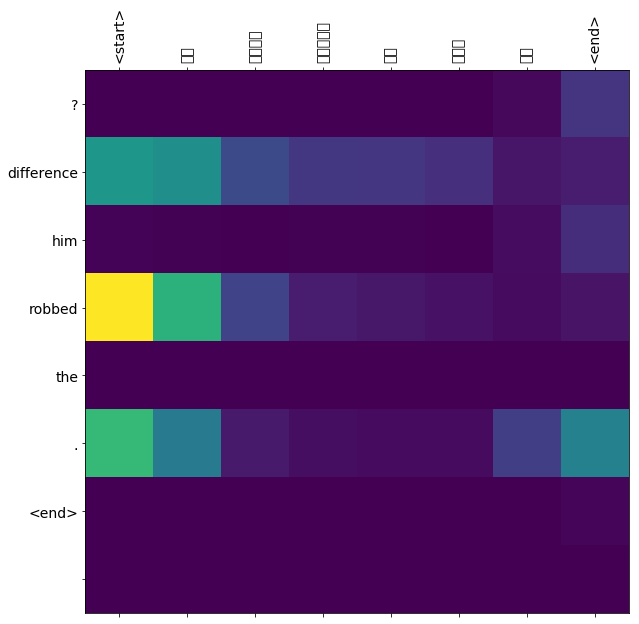

In [0]:
translate(u'वह अगले स्टॉप पर उतर गई')